# Data preprocessing

**Data loading:**

---



In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime

from tqdm.notebook import tqdm

# Import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    RandomizedSearchCV,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score

yield_raw_data = pd.read_csv('IL_yield.csv')
era5_raw_data = pd.read_csv('ERA5.csv')
evi_stack_data = pd.read_csv('EVI_stacked.csv')




**ERA5 preprocessing:**

---



Conversión de filas a columnas por campos 'county','long','lat','year'.
Conversión de temperaturas a Fº a Cº.

Redondeo de latitud y longitud para casar con el dataset de EVI y agrupación por media simple de grupos (year,county,long,lat)


In [23]:
era5_data = era5_raw_data.copy()
era5_data['time'] = pd.to_datetime(era5_data['time'])
era5_data['year'] = era5_data['time'].dt.year
era5_data['day'] = era5_data['time'].dt.dayofyear
era5_data['t2m'] = era5_data['t2m'] - 273.15 #to Celsius (Cº)
era5_data['leapyear'] = era5_data['time'].dt.is_leap_year
era5_data['day'] = era5_data.apply(lambda x : x['day']-1 if (x['leapyear'] and x['day']> 59) else x['day'], axis=1)
era5_data.pop('leapyear')
era5_stack_data = era5_data.pivot_table('t2m',['county','long','lat','year'],'day').rename_axis(None, axis=1)
era5_stack_data.reset_index(inplace=True)
era5Days = [col for col in era5_stack_data.columns if isinstance(col, int)]#era5Dats: days where era5 data is available
era5_stack_data.columns = [f't2m_{col}' if isinstance(col, int) else col for col in era5_stack_data.columns]
era5_stack_data = era5_stack_data.groupby(by=['county','year']).mean().rename_axis(None, axis=1)
era5_stack_data.reset_index(inplace=True)
era5_stack_data.sort_values(by=['county','year'], inplace=True)
era5_stack_data.reset_index(inplace=True, drop=True)
era5_stack_data.drop(['long','lat'], axis=1,inplace=True)
era5_stack_data.head()

,county,year,t2m_1,t2m_15,t2m_28,t2m_32,t2m_46,t2m_59,t2m_60,t2m_74,...,t2m_271,t2m_274,t2m_288,t2m_301,t2m_305,t2m_319,t2m_332,t2m_335,t2m_349,t2m_362
0,ADAMS,1979,-7.243292,-20.811003,-5.111502,-14.565009,2.269037,2.778970,2.189081,0.970056,...,22.624368,22.309045,14.633310,15.243829,13.714502,6.977686,1.895380,-1.248740,0.182001,-1.831091
1,ADAMS,1980,0.442514,5.439310,-9.558646,-11.698477,1.098795,1.387445,-9.818640,7.599268,...,15.049203,22.210977,18.015298,2.960016,11.645090,3.432245,0.572748,10.248529,1.780222,-2.549734
2,ADAMS,1981,2.304742,-0.446616,2.731699,1.020853,3.162180,17.414346,4.587396,7.885416,...,19.754327,28.039575,14.794733,9.830118,15.353952,11.364954,0.784982,4.444574,-1.062674,-0.453146
3,ADAMS,1982,-4.502509,-16.152151,5.373926,-8.137946,6.799142,1.823969,3.251184,5.113443,...,16.920984,24.755655,15.132684,15.539529,20.059076,-2.021704,2.650735,12.150995,4.447092,9.378015
4,ADAMS,1983,-1.008353,-2.839926,-2.979208,-2.273154,8.402902,6.715158,11.671732,7.532373,...,23.253488,22.017877,15.521936,17.395227,14.746454,8.943506,8.148935,-3.102927,-5.065741,-5.173361


**EVI preprocessing:**

---


Create synthetic observation for DOY=365.

In [24]:

#create synthetic observation for DOY=365. Will be useful for interpolation later (simple y=mx+b)
evi_stack_data['evi_365'] = ((evi_stack_data['evi_353']-evi_stack_data['evi_337'])/(353-337))*(365-337)+evi_stack_data['evi_337']
#replace column names to use them as DOY observation 
# evi_stack_data.columns = evi_stack_data.columns.str.replace("evi_", "")
evi_stack_data.head()


,year,county,long,lat,evi_1,evi_17,evi_33,evi_49,evi_65,evi_81,...,evi_225,evi_241,evi_257,evi_273,evi_289,evi_305,evi_321,evi_337,evi_353,evi_365
0,2001,ADAMS,-91.525,40.075,-0.146923,0.156453,-0.072903,-0.063690,-0.078860,-0.292650,...,0.127960,0.630331,0.057551,0.028800,0.224734,-0.037140,-0.054813,0.095283,0.132038,0.159604
1,2001,ADAMS,-91.525,40.125,-0.156214,-0.188116,-0.091597,-0.109840,-0.099103,0.021988,...,0.078727,-0.084846,0.029688,0.003740,-0.170605,-0.061510,-0.064935,-0.092197,-0.100994,-0.107592
2,2001,ADAMS,-91.525,40.175,0.000551,0.082851,0.108108,0.104726,0.101105,0.126727,...,0.454312,0.411025,0.357470,0.320813,0.237779,0.165385,0.161586,0.142840,0.017134,-0.077145
3,2001,ADAMS,-91.525,40.225,-0.005583,0.084916,0.116382,0.115102,0.107363,0.130750,...,0.462088,0.436204,0.374752,0.330077,0.250325,0.180660,0.169659,0.148152,0.017000,-0.081363
4,2001,ADAMS,-91.475,39.975,-0.030379,0.079086,0.107433,0.092655,0.078413,0.107965,...,0.531395,0.461023,0.335277,0.239753,0.155304,0.102718,0.097096,0.079518,0.084052,0.087451


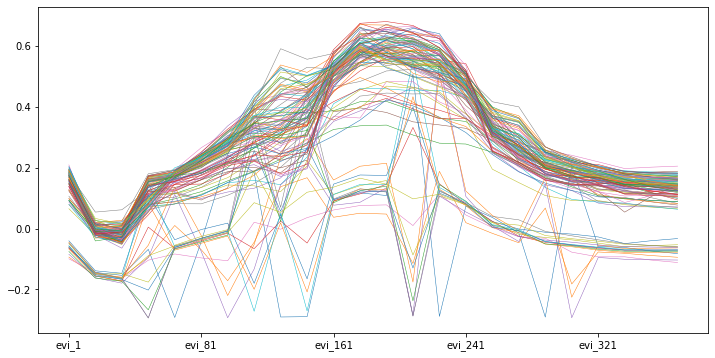

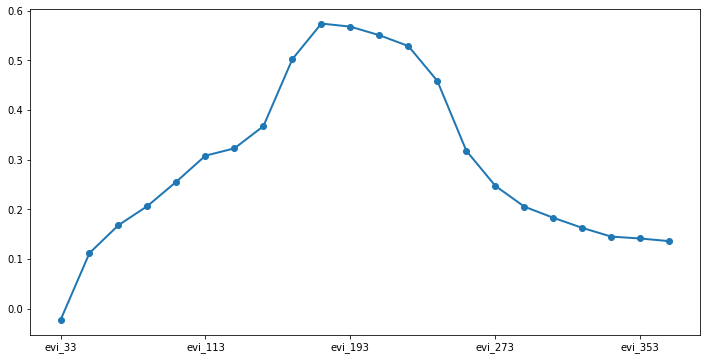

In [25]:

plt.rcParams["figure.figsize"] = (12,6)
#represent EVI observations for ADAMS county in 2001  
evi_stack_data[(evi_stack_data['county'] == "ADAMS") & (evi_stack_data['year'] == 2011)].iloc[:,4:].transpose().plot(legend=None, linewidth=0.5)
#represent EVI mean   
evi_stack_data[(evi_stack_data['county'] == "ADAMS") & (evi_stack_data['year'] == 2011)].groupby(by=['county','year']).median().iloc[:,4:].transpose().plot(legend=None,marker='o', linewidth=2)

plt.show()

Testing interpolation.

Text(0.5, 0.98, 'Interpolated EVI (ADAMS / 2011)')

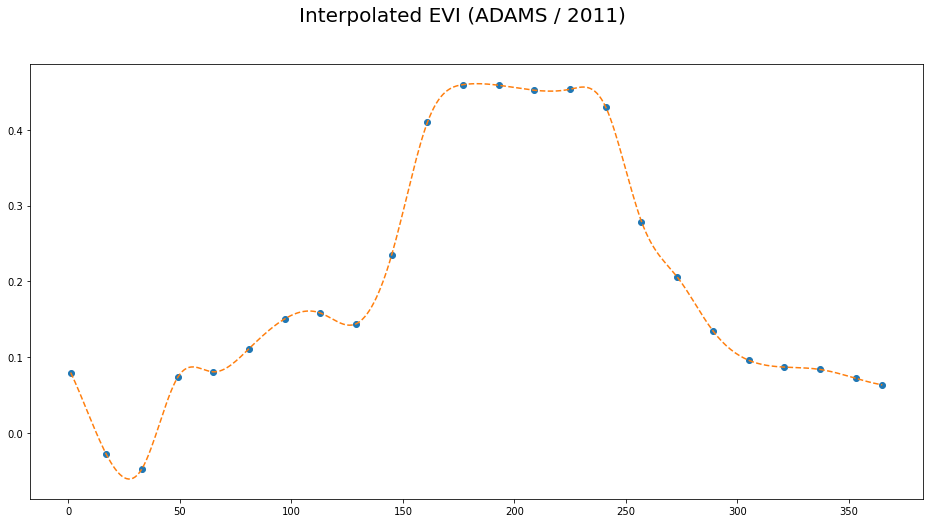

In [26]:
#Interpolate in order to obtain values for any DOY (will help us to match other observations)
from scipy.interpolate import interp1d

rowExample=9
sampleDf=evi_stack_data[(evi_stack_data['county'] == "ADAMS") & (evi_stack_data['year'] == 2011)].iloc[rowExample,4:]
sampleValues=sampleDf.values.astype(float)
sampleDates= [int(i.split('evi_')[1]) for i in evi_stack_data.columns[4:]]
xnew = np.linspace(1, 365, num=365, endpoint=True).round()

plt.rcParams["figure.figsize"] = (16,8)
evi_interp = interp1d(sampleDates, sampleValues,kind='cubic')
fig = plt.figure()
plt.plot(sampleDates, sampleValues, 'o', xnew, evi_interp(xnew), '--')
fig.suptitle('Interpolated EVI (ADAMS / 2011)', fontsize=20)


In [27]:
#Test to get EVI for any DOY
print(evi_interp(120))
print(evi_interp(3))
print(evi_interp(365))

0.14764285247539743
0.06668440235628238
0.06323693181818174


In [28]:
nRows, nColumns = evi_stack_data.shape
evi_stack_interpolate_data = evi_stack_data.copy()

evi_stack_data_doys = [float(i.split('evi_')[1]) for i in evi_stack_data.columns[4:]]
print(evi_stack_data_doys)


for i, row in tqdm(evi_stack_interpolate_data.iterrows(), desc='Interpolating', total=nRows):
  sampleDf=row.iloc[4:nColumns]
  sampleValues=sampleDf.values.astype(float)
  evi_interp = interp1d(evi_stack_data_doys, sampleValues,kind='cubic')
  for v in era5Days:#days where era5 data is available
    evi_stack_interpolate_data.at[i,v]=evi_interp(v)




evi_stack_interpolate_data.drop(evi_stack_interpolate_data.columns[4:28], axis = 1, inplace = True)

evi_stack_interpolate_data_doys = [float(i) for i in evi_stack_interpolate_data.columns[4:]]

evi_stack_interpolate_data.columns = [f'evi_{col}' if isinstance(col, int) else col for col in evi_stack_interpolate_data.columns]

print(evi_stack_interpolate_data_doys)




[1.0, 17.0, 33.0, 49.0, 65.0, 81.0, 97.0, 113.0, 129.0, 145.0, 161.0, 177.0, 193.0, 209.0, 225.0, 241.0, 257.0, 273.0, 289.0, 305.0, 321.0, 337.0, 353.0, 365.0]


Interpolating:   0%|          | 0/95418 [00:00<?, ?it/s]

[1.0, 15.0, 28.0, 32.0, 46.0, 59.0, 60.0, 74.0, 87.0, 91.0, 105.0, 118.0, 121.0, 135.0, 148.0, 152.0, 166.0, 179.0, 182.0, 196.0, 209.0, 213.0, 227.0, 240.0, 244.0, 258.0, 271.0, 274.0, 288.0, 301.0, 305.0, 319.0, 332.0, 335.0, 349.0, 362.0]


In [29]:
evi_stack_data.to_csv('EVI_stacked_interp')
evi_stack_interpolate_data.head(10)




,year,county,long,lat,evi_1,evi_15,evi_28,evi_32,evi_46,evi_59,...,evi_271,evi_274,evi_288,evi_301,evi_305,evi_319,evi_332,evi_335,evi_349,evi_362
0,2001,ADAMS,-91.525,40.075,-0.146923,0.168785,-0.006231,-0.062446,-0.079285,-0.037210,...,-0.001919,0.045682,0.226707,0.033028,-0.037140,-0.069577,0.053531,0.080468,0.130261,0.146198
1,2001,ADAMS,-91.525,40.125,-0.156214,-0.198122,-0.115016,-0.094961,-0.101376,-0.121790,...,0.022712,-0.007475,-0.167581,-0.093768,-0.061510,-0.059251,-0.086680,-0.090239,-0.099405,-0.105407
2,2001,ADAMS,-91.525,40.175,0.000551,0.076265,0.104627,0.107663,0.106235,0.100688,...,0.327285,0.317106,0.243627,0.177460,0.165385,0.160222,0.158848,0.150880,0.054094,-0.058439
3,2001,ADAMS,-91.525,40.225,-0.005583,0.077371,0.111302,0.115647,0.116627,0.109353,...,0.336944,0.326266,0.255805,0.193057,0.180660,0.169120,0.164861,0.156525,0.055576,-0.061859
4,2001,ADAMS,-91.475,39.975,-0.030379,0.070618,0.104993,0.107319,0.096962,0.079784,...,0.250542,0.234320,0.160082,0.110557,0.102718,0.097915,0.084480,0.081122,0.081341,0.087987
5,2001,ADAMS,-91.475,40.025,0.011736,0.066505,0.086642,0.087793,0.079487,0.073272,...,0.293629,0.286638,0.194531,0.139302,0.127395,0.096624,0.148086,0.162947,0.183818,0.183159
6,2001,ADAMS,-91.475,40.075,-0.148270,-0.125706,-0.105793,-0.102789,-0.107023,-0.110780,...,0.001940,-0.007579,-0.074614,-0.083373,-0.081542,-0.090963,-0.089962,-0.088079,-0.080779,-0.074891
7,2001,ADAMS,-91.475,40.125,-0.019611,0.068327,0.098039,0.100502,0.096916,0.094053,...,0.313557,0.301007,0.222989,0.156537,0.144062,0.134609,0.129351,0.121781,0.037631,-0.059054
8,2001,ADAMS,-91.475,40.175,-0.047713,0.035533,0.065429,0.068454,0.067320,0.065478,...,0.228545,0.214777,0.149362,0.104743,0.097584,0.096075,0.092882,0.086542,0.016047,-0.064902
9,2001,ADAMS,-91.475,40.225,-0.048605,0.045299,0.075261,0.077213,0.071271,0.067686,...,0.246718,0.230529,0.159575,0.114004,0.106429,0.102066,0.097972,0.091463,0.018176,-0.066178


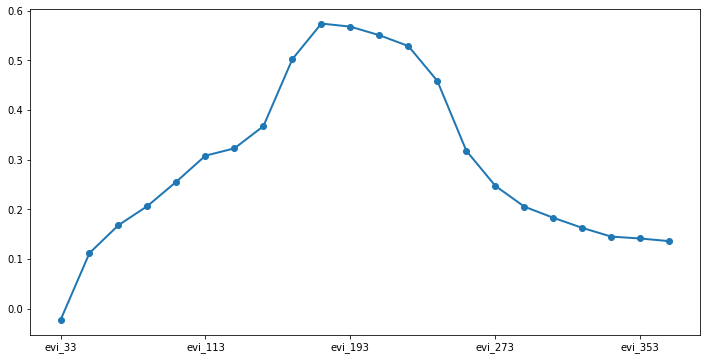

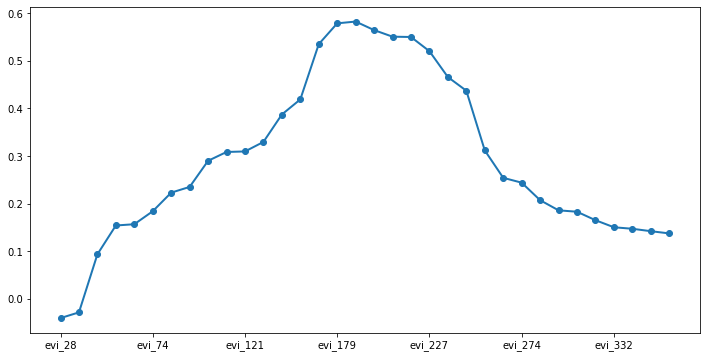

In [30]:
plt.rcParams["figure.figsize"] = (12,6)

#plt.plot(x1, y1, 'o', x2, y2, '--')

#represent EVI mean **interp** 
evi_stack_data[(evi_stack_data['county'] == "ADAMS") & (evi_stack_data['year'] == 2011)].groupby(by=['county','year']).median().iloc[:,4:28].transpose().plot(legend=None,marker='o', linewidth=2)
#represent EVI median **interp**   
evi_stack_interpolate_data[(evi_stack_interpolate_data['county'] == "ADAMS") & (evi_stack_interpolate_data['year'] == 2011)].groupby(by=['county','year']).median().iloc[:,4:].transpose().plot(legend=None,marker='o', linewidth=2)


plt.show()

Agrupación por media simple de grupos (year,county)

---



In [31]:
evi_stack_interpolate_data.sort_values(by=['county','year','long','lat'], inplace=True)
evi_stack_interpolate_data = evi_stack_interpolate_data.groupby(by=['county','year']).mean().rename_axis(None, axis=1)
evi_stack_interpolate_data.reset_index(inplace=True)
evi_stack_interpolate_data.drop(['long','lat'], axis=1,inplace=True)
evi_stack_interpolate_data.head()



,county,year,evi_1,evi_15,evi_28,evi_32,evi_46,evi_59,evi_60,evi_74,...,evi_271,evi_274,evi_288,evi_301,evi_305,evi_319,evi_332,evi_335,evi_349,evi_362
0,ADAMS,2001,-0.031036,0.080365,0.119704,0.123183,0.118161,0.111506,0.111546,0.126219,...,0.270480,0.262321,0.211996,0.173990,0.167336,0.160883,0.154451,0.151652,0.133635,0.115141
1,ADAMS,2002,0.117097,0.124487,0.119876,0.117955,0.114638,0.120248,0.121209,0.144489,...,0.236956,0.223094,0.195359,0.176619,0.167694,0.132797,0.129974,0.130816,0.117520,0.097976
2,ADAMS,2003,0.121478,0.011356,0.073473,0.092526,0.094674,0.085611,0.086294,0.118003,...,0.260288,0.246548,0.208413,0.180681,0.173535,0.152711,0.113268,0.101217,0.039386,-0.019764
3,ADAMS,2004,0.123930,0.147620,0.012384,-0.003672,0.106916,0.151562,0.150602,0.165326,...,0.263321,0.253424,0.197504,0.174428,0.167473,0.132564,0.140247,0.144105,0.136586,0.118964
4,ADAMS,2005,0.038249,0.108804,0.126521,0.127072,0.123500,0.118628,0.118376,0.120080,...,0.250106,0.246615,0.226196,0.215708,0.209727,0.158025,0.077051,0.062993,0.060886,0.083684


**Yield preprocessing:**

Eliminación de la tendencia de la Yield

---



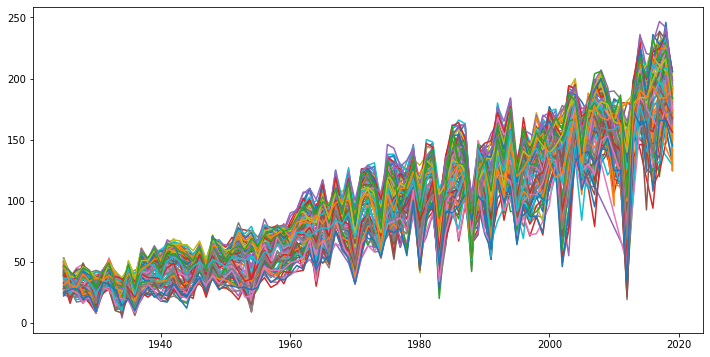

In [32]:
for _, group in yield_raw_data.groupby(by=['county']):

  plt.plot(group['year'], group['yield'])

plt.show()




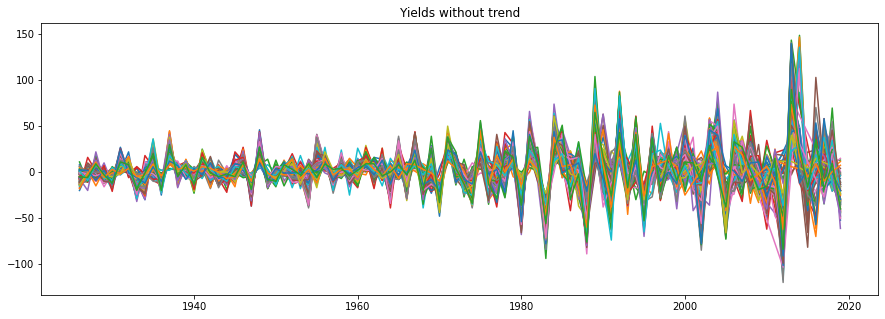

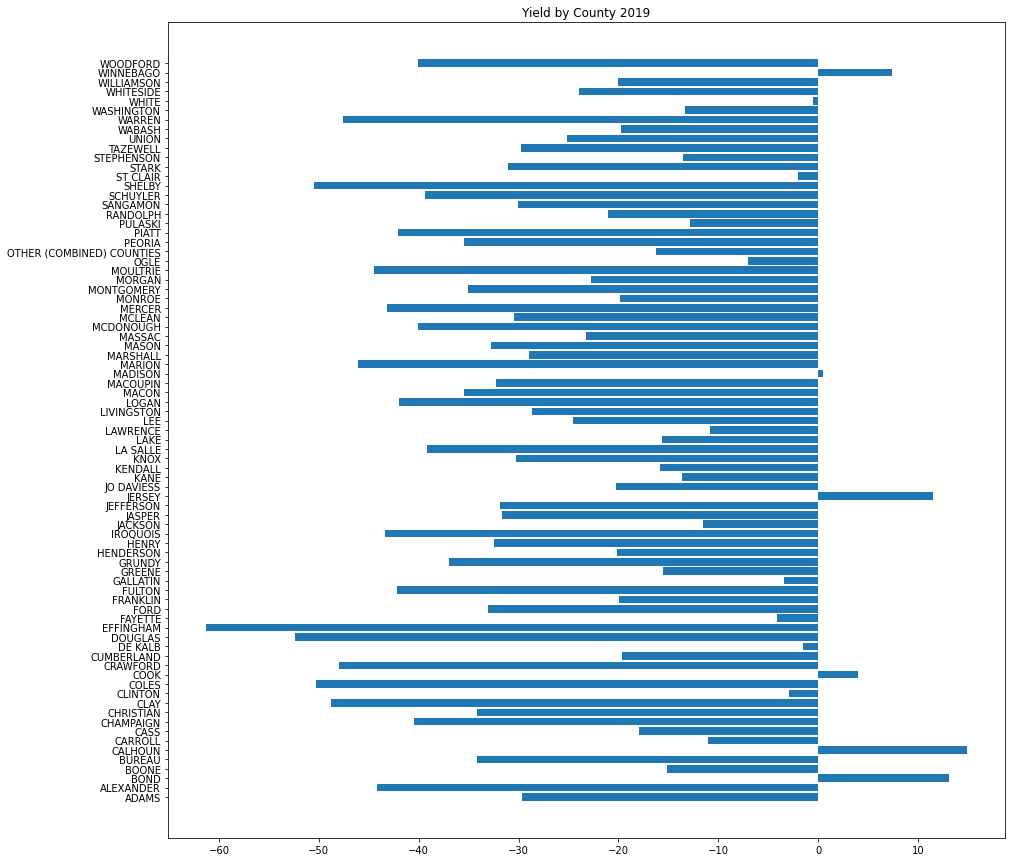

In [33]:
yield_custom_data = yield_raw_data.copy()


yield_custom_data = yield_custom_data.groupby(by=['county','year']).mean().rename_axis(None, axis=1)
yield_custom_data.reset_index(inplace=True)
yield_custom_data.reset_index(inplace=True, drop=True)


yield_custom_data['yield'] = yield_custom_data.sort_values(by=['county','year'], ascending=[True,True]).groupby(by=['county'])['yield'].diff()

fig1, ax1 = plt.subplots(figsize=(15,5))
ax1.title.set_text('Yields without trend')

for _, group in yield_custom_data.groupby(by=['county']):

  ax1.plot(group['year'], group['yield'])



fig2, ax2 = plt.subplots(figsize=(15,15))
ax2.title.set_text('Yield by County 2019')

ax2.barh(yield_custom_data[yield_custom_data.year == 2019]['county'],yield_custom_data[yield_custom_data.year == 2019]['yield'])

plt.show()


Creación del dataset definitivo mergeando los 3 dataset tratados.


---



In [34]:
df = pd.merge(evi_stack_interpolate_data, era5_stack_data,how='inner',on=['year','county'])
df = pd.merge(df, yield_custom_data, how='inner', on=['year','county'])


In [35]:
df[df.year == 2019].head(111)

,county,year,evi_1,evi_15,evi_28,evi_32,evi_46,evi_59,evi_60,evi_74,...,t2m_274,t2m_288,t2m_301,t2m_305,t2m_319,t2m_332,t2m_335,t2m_349,t2m_362,yield
17,ADAMS,2019,0.126653,-0.058563,0.063819,0.102965,0.130684,0.126141,0.126812,0.141748,...,28.241205,13.207666,12.455850,-1.214743,-1.499350,2.750604,9.985498,-2.860449,2.387216,-29.7
29,ALEXANDER,2019,0.093375,0.109266,0.113897,0.111775,0.091003,0.071469,0.070673,0.078900,...,28.522607,15.344263,14.360681,1.204156,4.623987,7.639429,15.577417,4.545648,10.621179,-44.2
41,BOND,2019,0.175877,0.175006,0.166794,0.164205,0.161991,0.179150,0.180405,0.179060,...,28.625085,13.309229,14.311487,0.548898,2.154977,4.489648,12.856577,-0.221579,5.082086,13.1
56,BOONE,2019,0.146953,0.010666,-0.010145,-0.015126,-0.038533,0.069744,0.081490,0.183750,...,26.780389,6.723230,9.595697,-2.231116,-4.395941,1.291589,3.118524,-3.688300,0.105829,-15.1
86,BUREAU,2019,0.126806,-0.021317,0.057760,0.082852,0.094192,0.109722,0.112433,0.146448,...,27.148859,8.784045,11.538483,-2.553894,-2.919275,1.998517,4.595929,-3.882843,0.406006,-34.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,WHITE,2019,0.181588,0.173342,0.181228,0.177006,0.139956,0.177315,0.182516,0.227938,...,30.429091,12.530084,12.349766,1.310734,1.346246,6.816441,14.026422,3.210219,8.958775,-0.5
1303,WHITESIDE,2019,0.128574,-0.009172,0.002866,0.005538,-0.020036,0.064545,0.074579,0.168146,...,27.421533,8.656732,11.270090,-1.864554,-3.735663,1.868997,4.210962,-4.376837,0.802988,-23.9
1332,WILLIAMSON,2019,0.184866,0.180538,0.174087,0.171149,0.162348,0.180075,0.182429,0.219501,...,29.370966,15.237695,14.129785,0.882669,3.348505,6.965494,14.954019,3.308435,9.803796,-20.0
1347,WINNEBAGO,2019,0.163790,0.010344,0.000818,-0.001821,-0.032297,0.071193,0.083047,0.191862,...,26.930643,7.196817,9.821100,-2.246161,-4.676917,1.282037,3.174997,-3.834937,0.903635,7.4


In [36]:
df.to_csv('crop_output.csv')

In [37]:
# https://github.com/Cosechas-IA/crop-prediction

import pandas as pd

# Import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
)
from sklearn.ensemble import RandomForestRegressor

In [38]:
# Convertir el county
categorical_features_one_hot = pd.get_dummies(df)
categorical_features_one_hot.head()

,year,evi_1,evi_15,evi_28,evi_32,evi_46,evi_59,evi_60,evi_74,evi_87,...,county_WABASH,county_WARREN,county_WASHINGTON,county_WAYNE,county_WHITE,county_WHITESIDE,county_WILL,county_WILLIAMSON,county_WINNEBAGO,county_WOODFORD
0,2001,-0.031036,0.080365,0.119704,0.123183,0.118161,0.111506,0.111546,0.126219,0.162237,...,0,0,0,0,0,0,0,0,0,0
1,2002,0.117097,0.124487,0.119876,0.117955,0.114638,0.120248,0.121209,0.144489,0.171521,...,0,0,0,0,0,0,0,0,0,0
2,2003,0.121478,0.011356,0.073473,0.092526,0.094674,0.085611,0.086294,0.118003,0.160007,...,0,0,0,0,0,0,0,0,0,0
3,2004,0.123930,0.147620,0.012384,-0.003672,0.106916,0.151562,0.150602,0.165326,0.214747,...,0,0,0,0,0,0,0,0,0,0
4,2005,0.038249,0.108804,0.126521,0.127072,0.123500,0.118628,0.118376,0.120080,0.141365,...,0,0,0,0,0,0,0,0,0,0


In [39]:
y = categorical_features_one_hot["yield"]
X = categorical_features_one_hot.drop(["yield"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [40]:
model = RandomForestRegressor()
scoring = "neg_mean_squared_error"

kfold = KFold(n_splits=5)
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

model.fit(X_train, y_train)

y_predicts = model.predict(X_test)
print(
    """
        Model {}
        Mean {}
        Mean Squared Error: {}
        Std {}
        R2: {}
     """.format(
        RandomForestRegressor.__name__,
        -results.mean(), 
        np.sqrt(metrics.mean_squared_error(y_test, y_predicts)),
        results.std(),
        r2_score(y_test, y_predicts),
    )
)



        Model RandomForestRegressor
        Mean 222.03503872293578
        Mean Squared Error: 14.613049181751162
        Std 39.05794223111091
        R2: 0.8619857542389765
     


In [41]:
param_grid = {
    "bootstrap": [True, False],
    "max_depth": [2, 4, 8],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_split": [2, 4, 8],
    "n_estimators": [200, 400, 600],
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
)

random_search_result = random_search.fit(X_train, y_train)

print("Best Params: ", random_search_result.best_params_)


Best Params:  {'n_estimators': 600, 'min_samples_split': 8, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': True}


In [42]:
model = RandomForestRegressor(
    n_estimators=600, min_samples_split=8, max_features="sqrt", max_depth=8, bootstrap=True
)
scoring = "neg_mean_squared_error"

kfold = KFold(n_splits=5)
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

model.fit(X_train, y_train)

y_predicts = model.predict(X_test)
print(
    """
        Model {}
        Mean {}
        Mean Squared Error: {}
        Std {}
        R2: {}
     """.format(
        RandomForestRegressor.__name__,
        -results.mean(), 
        np.sqrt(metrics.mean_squared_error(y_test, y_predicts)),
        results.std(),
        r2_score(y_test, y_predicts),
    )
)


        Model RandomForestRegressor
        Mean 236.9409286474288
        Mean Squared Error: 15.492743162212664
        Std 42.526259513714244
        R2: 0.8448689018122937
     
